# VAE Image Generation

Purpose: Generate new images from trained VAE latent space.

Includes: sampling and decoding  
Excludes: training and evaluation


In [5]:
import sys
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np

current = Path().resolve()
while not (current / "src").exists():
    current = current.parent

sys.path.append(str(current))
print("Project root:", current)


Project root: /workspace


In [26]:
from src.models.vae import ConvVAE
from src.datasets.grayscale_datasets import get_grayscale_loader


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

latent_dim = 32


Using device: cpu


In [28]:
def show_grid(images, title, nrow=8):
    images = images[:nrow*nrow]
    fig, axes = plt.subplots(nrow, nrow, figsize=(nrow, nrow))
    fig.suptitle(title)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


In [32]:
def decode_from_latent(model, z):
    """
    Correct latent decoding for YOUR ConvVAE architecture.
    """
    with torch.no_grad():
        h = model.decoder.fc(z)              # (B, 6272)
        h = h.view(z.size(0), 128, 7, 7)      # correct spatial size
        out = model.decoder.deconv(h)         # ConvTranspose stack
    return out


In [7]:
from pathlib import Path
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

# Desktop path (works on Linux / Mac / Windows)
desktop_dir = Path.home() / "Desktop"
desktop_dir.mkdir(exist_ok=True)

def show_grid(images, title, nrow=8, save_path=None):
    fig, ax = plt.subplots(figsize=(nrow, nrow))
    ax.set_title(title)
    ax.axis("off")

    grid = torchvision.utils.make_grid(
        torch.tensor(images, dtype=torch.float32).unsqueeze(1),
        nrow=nrow,
        padding=2
    )

    ax.imshow(grid.permute(1, 2, 0), cmap="gray")

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Saved to: {save_path}")

    plt.close(fig)
    plt.show()


datasets = ["mnist", "fashion", "emnist"]

for ds in datasets:
    print(f"\n=== {ds.upper()} : ORIGINAL vs RECON ===")

    loader = get_grayscale_loader(
        dataset_name=ds,
        root=current / "data" / "raw",
        batch_size=64
    )

    ckpt_path = current / "checkpoints" / "grayscale" / f"vae_{ds}_64.pt"
    model = ConvVAE(latent_dim=latent_dim).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    with torch.no_grad():
        x, _ = next(iter(loader))
        x = x.to(device)[:64]

        recon, _, _ = model(x)

        x = (x + 1) / 2
        recon = (recon + 1) / 2

        combined = np.concatenate(
            [
                x.cpu().numpy().squeeze(1),
                recon.cpu().numpy().squeeze(1)
            ],
            axis=0
        )

    save_path = desktop_dir / f"{ds}_orig_vs_recon.png"

    show_grid(
        combined,
        f"{ds.upper()} — Original (top) vs Reconstruction (bottom)",
        nrow=8,
        save_path=save_path
    )



=== MNIST : ORIGINAL vs RECON ===


NameError: name 'get_grayscale_loader' is not defined


=== MNIST : RANDOM LATENT SAMPLES ===


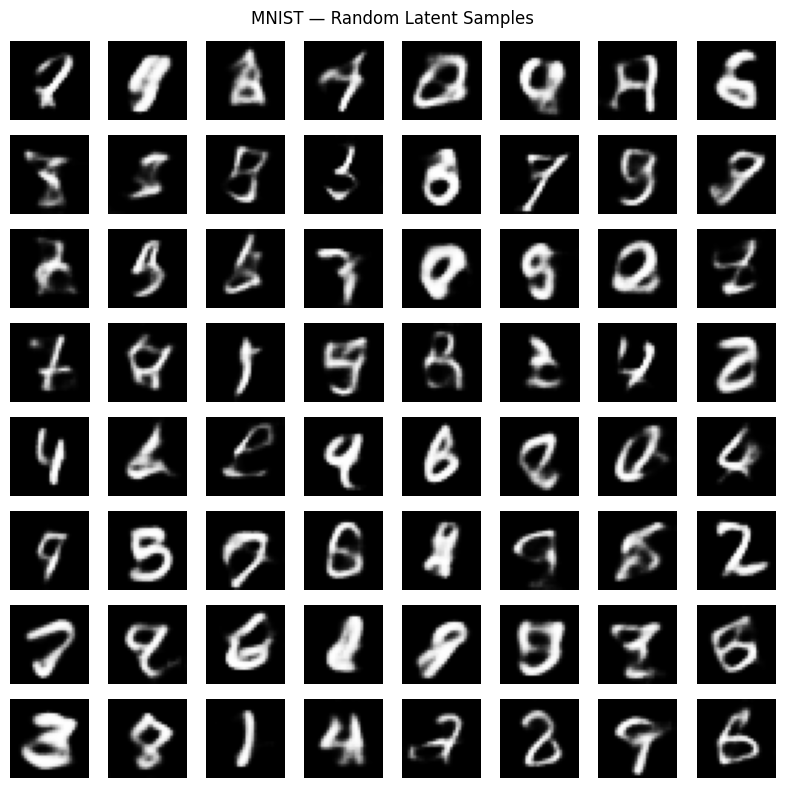


=== FASHION : RANDOM LATENT SAMPLES ===


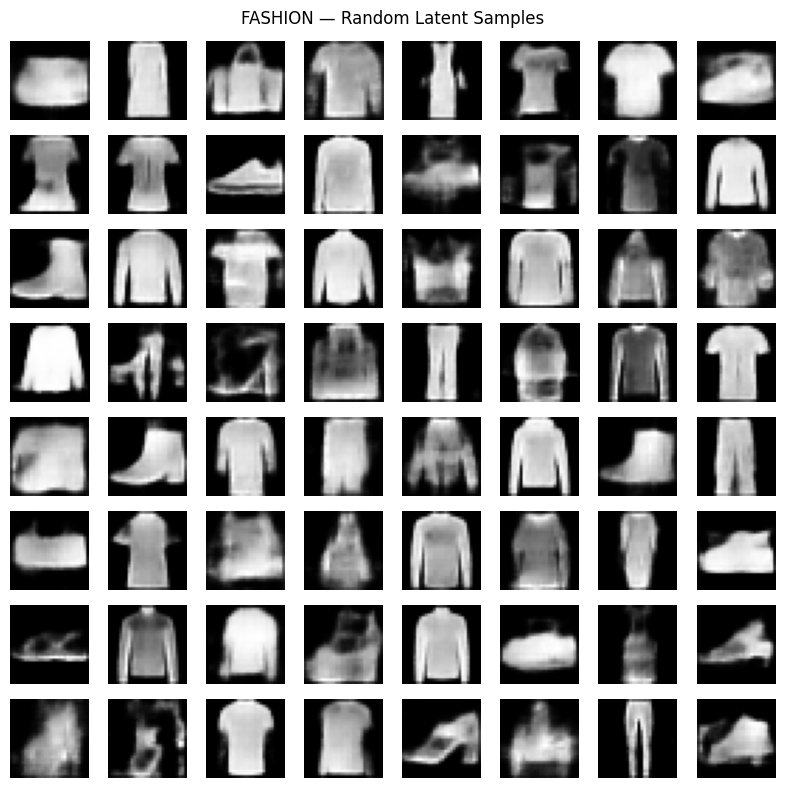


=== EMNIST : RANDOM LATENT SAMPLES ===


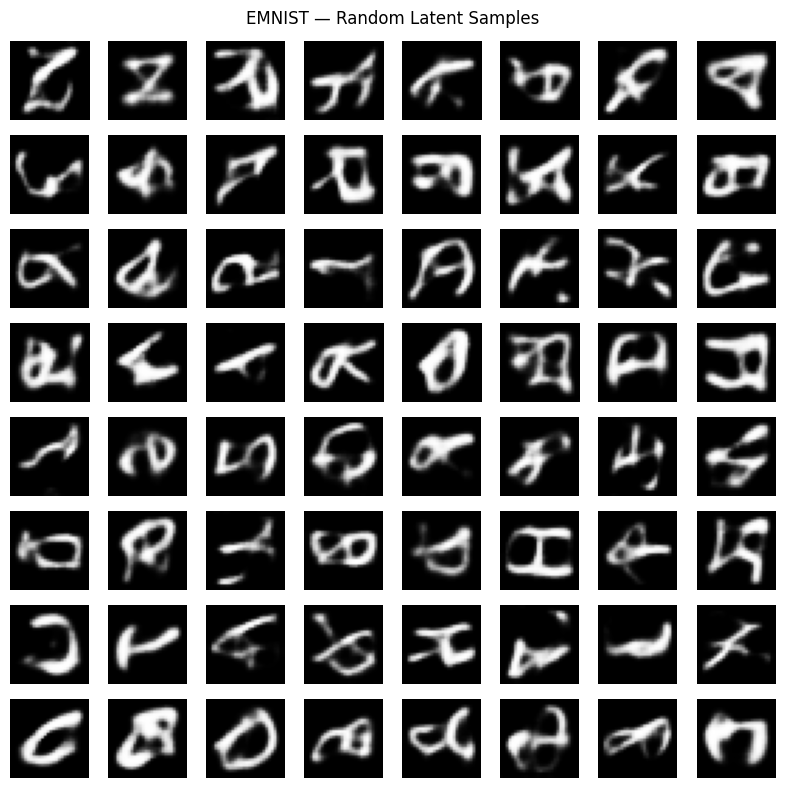

In [34]:
for ds in datasets:
    print(f"\n=== {ds.upper()} : RANDOM LATENT SAMPLES ===")

    ckpt_path = current / "checkpoints" / "grayscale" / f"vae_{ds}_64.pt"
    model = ConvVAE(latent_dim=latent_dim).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    z = torch.randn(64, latent_dim).to(device)
    samples = decode_from_latent(model, z)

    samples = (samples + 1) / 2
    samples = samples.cpu().numpy().squeeze(1)

    show_grid(
        samples,
        f"{ds.upper()} — Random Latent Samples",
        nrow=8
    )
